# Diabetes BRFSS 2015 – Analysis (ML Zoomcamp style)

Datasets:
- `diabetes_012_health_indicators_BRFSS2015.csv`
- `diabetes_binary_5050split_health_indicators_BRFSS2015.csv`
- `diabetes_binary_health_indicators_BRFSS2015.csv`

This notebook mirrors the structure of your **ML ZoomCamp - Midterm Project** analysis:
- Data loading & inspection
- Class imbalance
- Risk tables (who is more at risk?)
- Correlation analysis
- Simple baseline models (Logistic Regression, XGBoost)

Set `DATASET` to `'binary'`, `'binary_5050'`, or `'012'` and run all cells.

In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

sns.set(style="whitegrid")

## 1. Load and inspect data

In [60]:
# Choose which dataset to analyse: 'binary', 'binary_5050', or '012'
DATASET = "binary"   # change this and re-run the notebook

if DATASET == "binary":
    file_name = "data/diabetes_binary_health_indicators_BRFSS2015.csv"
    target_col = "Diabetes_binary"
elif DATASET == "binary_5050":
    file_name = "data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv"
    target_col = "Diabetes_binary"
elif DATASET == "012":
    file_name = "data/diabetes_012_health_indicators_BRFSS2015.csv"
    target_col = "Diabetes_012"
else:
    raise ValueError("DATASET must be 'binary', 'binary_5050', or '012'")

df = pd.read_csv(file_name)

print("Dataset:", DATASET)
print("File:", file_name)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset: binary
File: data/diabetes_binary_health_indicators_BRFSS2015.csv
Shape: (253680, 22)
Columns: ['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


In [61]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [63]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,253680.0,0.139333,0.346294,0.0,0.0,0.0,0.0,1.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


In [64]:
df[target_col].value_counts(normalize=True)

Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64

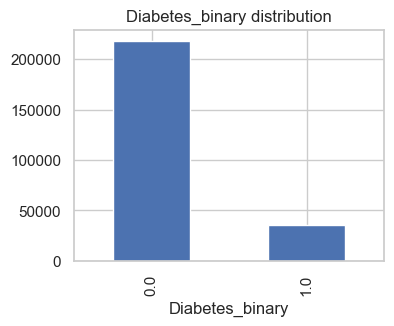

In [65]:
plt.figure(figsize=(4,3))
df[target_col].value_counts().plot(kind="bar")
plt.title(f"{target_col} distribution")
plt.show()

## 2. Data cleaning & formatting

- These BRFSS datasets have no missing values.
- All columns are numeric (floats), representing either:
  - binary flags (0/1), or
  - encoded categorical levels (Age, GenHlth, Education, Income).

So data cleaning is minimal compared to typical free-text or mixed-type datasets.

In [66]:
df.isnull().sum().sum()

np.int64(0)

## 3. Risk tables – who is more at risk?

We'll create helper functions to compute:
- $P(\text{diabetes} \mid \text{feature value})$ for each category.
- For the 012 dataset, we treat `Diabetes_012 > 0` as "has diabetes / pre-diabetes".

In [67]:
def get_binary_target(df, target_col):
    if target_col == "Diabetes_012":
        # collapse 1 & 2 to 1 (pre-diabetes or diabetes)
        return (df[target_col] > 0).astype(int)
    else:
        return df[target_col].astype(int)


def risk_by_feature(df, target_col, feature):
    y = get_binary_target(df, target_col)
    return df.assign(_target=y).groupby(feature)["_target"].mean()

HighBP
0.0    0.060352
1.0    0.244457
Name: _target, dtype: float64


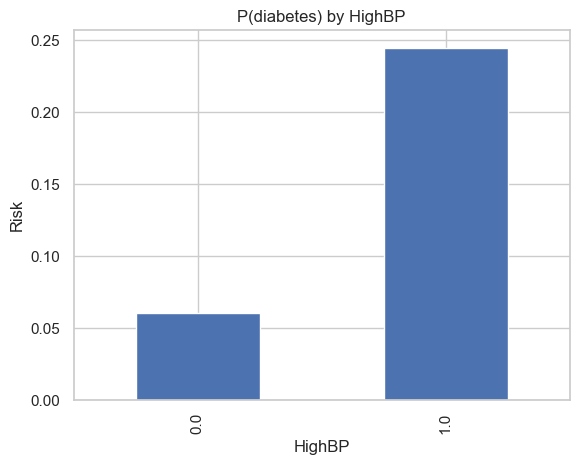

In [68]:
# Example: risk by HighBP
risk_hp = risk_by_feature(df, target_col, "HighBP")
print(risk_hp)

risk_hp.plot(kind="bar")
plt.title("P(diabetes) by HighBP")
plt.ylabel("Risk")
plt.show()

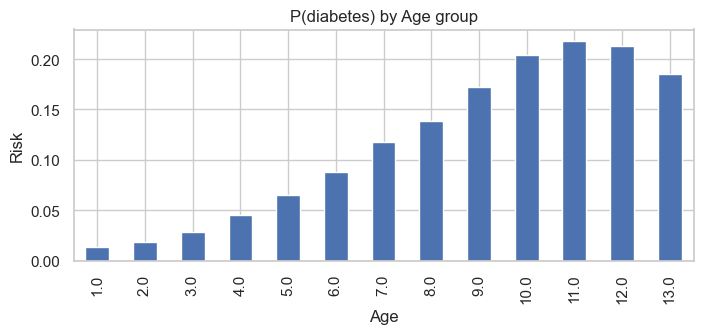

In [69]:
# Example: risk by Age (encoded age groups)
risk_age = risk_by_feature(df, target_col, "Age")
risk_age.plot(kind="bar", figsize=(8,3))
plt.title("P(diabetes) by Age group")
plt.ylabel("Risk")
plt.show()

BMI_bin
underweight    0.054045
normal         0.062475
overweight     0.126821
obese I        0.211527
obese II       0.285311
obese III      0.338270
Name: diab_binary, dtype: float64


/var/folders/3w/lgxfkvyj75j2bjhyt_tft6000000gn/T/ipykernel_45710/3861083583.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_bmi = df_temp.groupby("BMI_bin")["diab_binary"].mean()


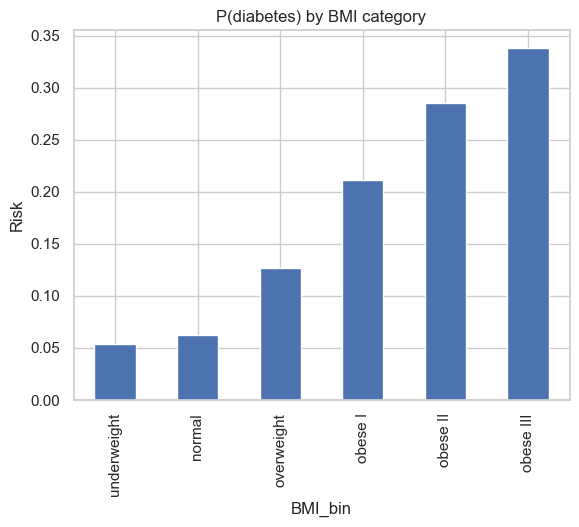

In [70]:
# Example: risk by BMI bins
df_temp = df.copy()
df_temp["diab_binary"] = get_binary_target(df_temp, target_col)

df_temp["BMI_bin"] = pd.cut(
    df_temp["BMI"],
    bins=[0, 18.5, 25, 30, 35, 40, 100],
    labels=["underweight","normal","overweight","obese I","obese II","obese III"],
)

risk_bmi = df_temp.groupby("BMI_bin")["diab_binary"].mean()
print(risk_bmi)

risk_bmi.plot(kind="bar")
plt.title("P(diabetes) by BMI category")
plt.ylabel("Risk")
plt.show()

Income
1.0    0.242891
2.0    0.261903
3.0    0.223084
4.0    0.201341
5.0    0.174014
6.0    0.145078
7.0    0.121821
8.0    0.079604
Name: _target, dtype: float64


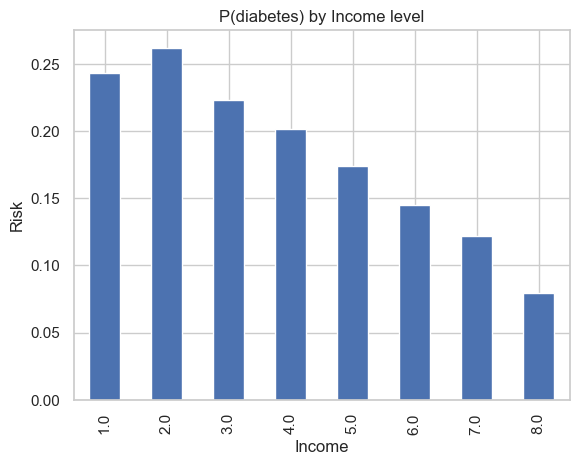

In [71]:
# Example: risk by Income level
risk_income = risk_by_feature(df, target_col, "Income")
print(risk_income)

risk_income.plot(kind="bar")
plt.title("P(diabetes) by Income level")
plt.ylabel("Risk")
plt.show()

## 4. Correlation analysis

Since all features are numeric, we can:
- Compute Pearson correlation between each feature and the target.
- Visualize a heatmap of correlations among numeric features.

In [72]:
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_no_target = [c for c in numeric if c != target_col]

corrs = df[numeric_no_target].corrwith(df[target_col]).sort_values(
    key=lambda s: s.abs(), ascending=False
)
corrs

GenHlth                 0.293569
HighBP                  0.263129
DiffWalk                0.218344
BMI                     0.216843
HighChol                0.200276
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Income                 -0.163919
Education              -0.124456
PhysActivity           -0.118133
Stroke                  0.105816
MentHlth                0.069315
CholCheck               0.064761
Smoker                  0.060789
HvyAlcoholConsump      -0.057056
Veggies                -0.056584
Fruits                 -0.040779
NoDocbcCost             0.031433
Sex                     0.031430
AnyHealthcare           0.016255
dtype: float64

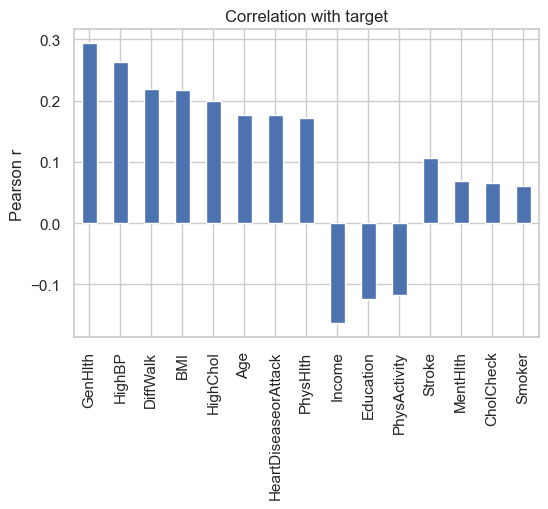

In [73]:
plt.figure(figsize=(6,4))
corrs.head(15).plot(kind="bar")
plt.title("Correlation with target")
plt.ylabel("Pearson r")
plt.show()

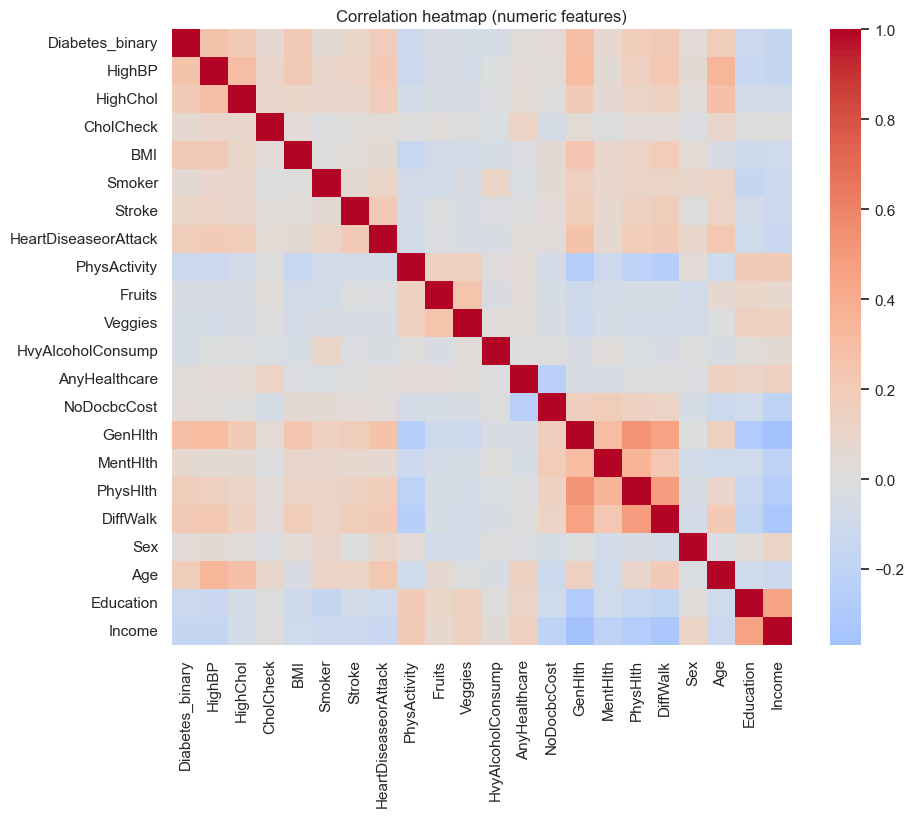

In [74]:
plt.figure(figsize=(10,8))
corr_matrix = df[numeric].corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.show()

## 5. Simple modeling – Logistic Regression & XGBoost

Similar to the ML ZoomCamp midterm project:
- Split into train/val/test (60/20/20).
- Use `DictVectorizer` to vectorize features.
- Train Logistic Regression as a baseline.
- Train XGBoost as a stronger model.
- Evaluate ROC AUC (on a binary target derived from the original).

In [75]:
# Train/Val/Test split
df_full_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=1,
    stratify=df[target_col],
)

df_train, df_val = train_test_split(
    df_full_train,
    test_size=0.25,  # 0.25 of 0.8 = 0.2 of full
    random_state=1,
    stratify=df_full_train[target_col],
)

for name, part in [("train", df_train), ("val", df_val), ("test", df_test)]:
    print(name, part.shape)

y_train = get_binary_target(df_train, target_col)
y_val   = get_binary_target(df_val, target_col)
y_test  = get_binary_target(df_test, target_col)

feature_cols = [c for c in df.columns if c != target_col]

# DictVectorizer
dv = DictVectorizer(sparse=False)

train_dicts = df_train[feature_cols].to_dict(orient="records")
val_dicts   = df_val[feature_cols].to_dict(orient="records")
test_dicts  = df_test[feature_cols].to_dict(orient="records")

X_train = dv.fit_transform(train_dicts)
X_val   = dv.transform(val_dicts)
X_test  = dv.transform(test_dicts)

train (152208, 22)
val (50736, 22)
test (50736, 22)


In [76]:
# Baseline: Logistic Regression (binary target)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_val_proba = log_reg.predict_proba(X_val)[:, 1]
auc_log_reg = roc_auc_score(y_val, y_val_proba)
print("Validation ROC AUC (LogReg, binary target):", auc_log_reg)

Validation ROC AUC (LogReg, binary target): 0.8235569779196374


In [83]:
# XGBoost model (binary objective on collapsed target)

feature_names = dv.get_feature_names_out().tolist()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval   = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)
dtest  = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 20,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

watchlist = [(dtrain, "train"), (dval, "val")]

model_xgb = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,
    evals=watchlist,
    verbose_eval=False,
)

y_val_pred = model_xgb.predict(dval)
auc_xgb = roc_auc_score(y_val, y_val_pred)
print("Validation ROC AUC (XGBoost, binary target):", auc_xgb)

# Evaluate on test set
y_test_pred = model_xgb.predict(dtest)
test_auc_xgb = roc_auc_score(y_test, y_test_pred)
print("Test ROC AUC (XGBoost, binary target):", test_auc_xgb)

Validation ROC AUC (XGBoost, binary target): 0.8310790810127611
Test ROC AUC (XGBoost, binary target): 0.8302013865575839
